In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal
import cusignal
import pandas as pd
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
from fastai.vision.augment import RandTransform
import torch
torch.cuda.set_device(0) 


def snomedConvert(code,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        df.columns = [codes[codes["SNOMED CT Code"] == int(x)].iloc[0]["Dx"] for x in df.columns]
        return df
df = pd.read_csv("data/WFDB_CPSC2018.csv")
codes =  pd.read_csv("data/codes.csv",sep=";")
# df.columns = [codes[codes["SNOMED CT Code"] == x].iloc[0]["Dx"] for x in df.columns]
np.sum(codes["SNOMED CT Code"] == int(df.columns[0]))

1

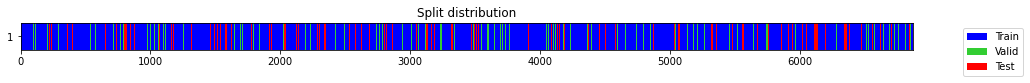

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [60]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(df)
y = y[y.columns[0]].to_numpy()
splits = get_splits(y, valid_size=.1,test_size=0.1, stratify=True, random_state=23, shuffle=True)
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

In [61]:
tfms  = [TSNormalize(), TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 
# model = InceptionTimePlus(dls.vars, dls.c, dls.len, conv_dropout=0.01, depth=6,)
# learn = Learner(dls, model, metrics=metrics, cbs=ShowGraph())
# learn.fit_one_cycle(20, lr_max=0.04178080960048705)
# learn.recorder.plot_metrics()

#### Which transformations do we want to use?

In [62]:
class Normalize(RandTransform):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        output = o.clone()
        for i in range(len(o)):
            output[i] = output[i]/output[i].max()
        return output
class Resample(RandTransform):
    def __init__(self, size=None, scale_factor=None,**kwargs):
        self.size = size
        self.scale_factor = scale_factor
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        output = F.interpolate(o,self.size,self.scale_factor)
        return output

In [79]:
TSMagAddNoise?

Init signature: TSMagAddNoise(self, magnitude=1, ex=None, **kwargs)
Docstring:      Applies additive noise on the y-axis for each step of a `TSTensor` batch
File:           ~/miniconda3/envs/ddsp/lib/python3.8/site-packages/tsai/data/transforms.py
Type:           _TfmMeta
Subclasses:     


In [110]:
tfm = TSMagMulNoise(magnitude=1)

norm = Normalize()
xb = dsets[0:2][0]
# xb = F.interpolate(xb,1250)
changed = np.array(tfm.encodes(norm.encodes(xb)))


array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

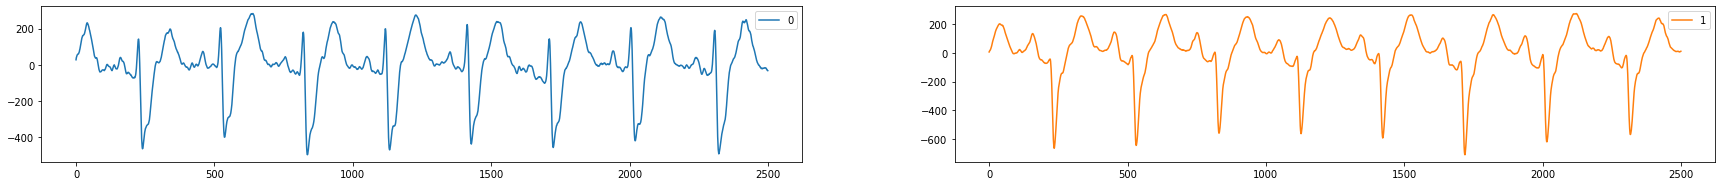

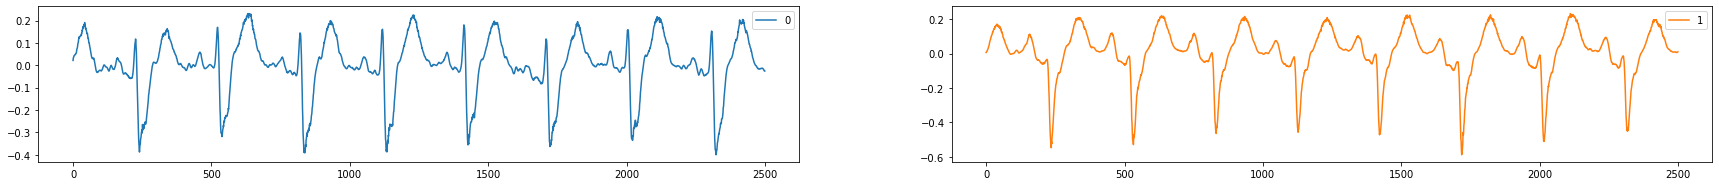

In [111]:
# diff = xb[0]-changed[0]
pd.DataFrame(xb[0][0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))
pd.DataFrame(changed[0][0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))
# fig = pd.DataFrame(diff[0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

# Done:
- scores to beat
- hyperparam search
- decided which model(s) to use
# Need to do:
1. Filtering (GPU filtering?)
2. non-DL augmentation methods
